# Assignment 3: Understanding cross validation and grid search

In this notebook, you will work through a series of exercises designed to deepen your understanding of cross validation and grid search methods using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In [77]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

As in the previous assignment, the following cell provides two functions: one for result visualization and another for synthetic data generation. **Please DO NOT MODIFY** these functions.

You may reuse parts of this code for the final open-ended question, but ensure that both functions remain unchanged in their original forms for the guided exercises.

- The `plot_decision_surface` function creates a scatter plot showing training data points (represented by circles) and test data points (diamonds), along with the model's decision boundary.

- The `make_spirals` function generates a synthetic dataset in a spiral pattern, suitable for testing complex decision boundaries.
  
</div>

In [78]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import pandas as pd

set_config(transform_output="pandas")


def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def make_spirals(n_samples=100, noise=0, n_turns=2.5, random_state=42, spread=1.0):
    np.random.seed(random_state)
    n_class = int(np.ceil(n_samples / 2))
    n = np.sqrt(np.random.rand(n_class, 1)) * n_turns * (2 * np.pi)
    d1x = -np.cos(n) * n * spread
    d1y = np.sin(n) * n * spread

    X = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y))))
    X += noise * np.random.randn(*X.shape)
    y = np.hstack([np.zeros(n_class), np.ones(n_class)])
    X = X[:n_samples]
    y = y[:n_samples]
    return X, y

<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_spirals` function defined in this notebook with the parameters: `n_samples=625`, `noise=0.3`, and `spread=0.5`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.


<br><i>[0.25 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

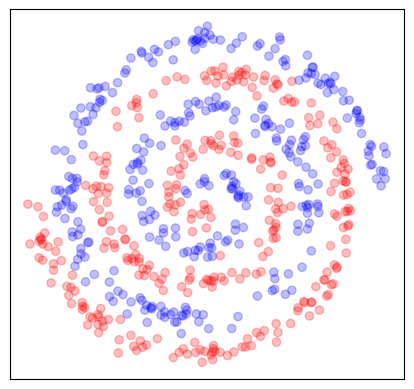

In [79]:
# YOUR CODE HERE
X, y = make_spirals(n_samples=625, noise=0.3, spread=0.5)
plot_decision_surface(X, y)


In [80]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Train-test split </b>

Write code to split the generated dataset into training and testing sets using scikit learn, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, X_test, y_train, and y_test. After creating the dataset, call again plot_decision_surface(X_train, y_train, X_test, y_test) to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

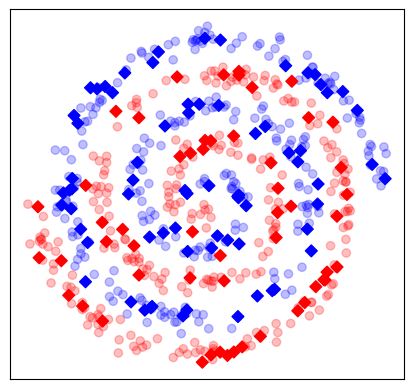

In [81]:
# YOUR CODE HERE
# Importing necessary libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the decision surface showing both training and testing data
plot_decision_surface(X_train, y_train, X_test, y_test)


In [82]:
# LEAVE BLANK

In [83]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Create cross-validation folds </b>

After splitting the complete dataset into training and test sets, the next step is to implement a 5-fold stratified cross-validation strategy to assess our model’s performance. Write code to create a list named `fold_indexes`, which will store the training sample indices used in each fold. 

Each of the five elements in `fold_indexes` should contain an array of sample indices specific to that fold. Since the synthetic dataset is balanced, ensure that each fold remains stratified by including 50% of indices from samples where `y_train == 0` and 50% from samples where `y_train == 1`.

<br><i>[1 point]</i>
</div>

<div class="alert alert-warning">

Store only the sample indices in the `fold_indexes` list, not the actual values. This way, you can later retrieve both the sample values and their corresponding target labels in the following exercises.

</div>

In [84]:
# YOUR CODE HERE
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object for 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the list to store the fold indices
fold_indexes = []

# Generate the fold indices
for train_index, _ in skf.split(X_train, y_train):
    fold_indexes.append(train_index)

# Check the fold_indexes
print(fold_indexes)


[array([  0,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  21,  22,  23,  24,  26,  28,  29,  32,  33,
        35,  37,  38,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,
        66,  67,  68,  69,  71,  73,  74,  75,  76,  79,  80,  81,  82,
        83,  84,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98, 100, 102, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114,
       115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 146, 147, 149, 150, 151, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173,
       174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 197, 200, 203, 204, 205,
       207, 208, 209, 210, 212, 213, 214, 215, 216, 219, 221, 2

In [85]:
# LEAVE BLANK

In [86]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 4: Create folds combinations</b>

Once the folds are created, write code to generate the index combinations for the training and validation sets at each cross-validation step. Store these combinations in a list named `folds`, which should contain five tuples. Each tuple should have two elements:

1. The indices for the training samples (i.e., the combined indices of the four folds used for training).
2. The indices for the validation samples (i.e., the indices of the fold designated for validation in that step).

<br><i>[1 point]</i>
</div>

In [87]:
# YOUR CODE HERE
# Importing necessary libraries
import numpy as np

# Assuming fold_indexes has been created from Exercise 3
# fold_indexes is a list of indices from each fold

# List to store the fold combinations (train, validation)
folds = []

# For each fold, generate the training and validation sets
for i in range(5):
    # Validation set is the current fold
    val_indices = fold_indexes[i]
    
    # Training set is the combination of all other folds
    train_indices = np.concatenate([fold_indexes[j] for j in range(5) if j != i])
    
    # Append the tuple of (train_indices, val_indices) to the folds list
    folds.append((train_indices, val_indices))

# Check the folds
for idx, (train, val) in enumerate(folds):
    print(f"Fold {idx+1}:")
    print(f"Train indices: {train[:5]}...")  # Displaying first 5 indices for brevity
    print(f"Validation indices: {val[:5]}...")
    print()


Fold 1:
Train indices: [1 2 3 4 5]...
Validation indices: [0 2 3 4 6]...

Fold 2:
Train indices: [0 2 3 4 6]...
Validation indices: [1 2 3 4 5]...

Fold 3:
Train indices: [0 2 3 4 6]...
Validation indices: [0 1 2 3 5]...

Fold 4:
Train indices: [0 2 3 4 6]...
Validation indices: [0 1 2 3 4]...

Fold 5:
Train indices: [0 2 3 4 6]...
Validation indices: [0 1 4 5 6]...



In [88]:
# LEAVE BLANK

In [89]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Generate model candidates for the grid search </b>

Write code to create a collection of decision tree model candidates using the following hyperparameters:

- `max_depth`: [None, 3, 5, 7]
- `criterion`: ['gini', 'entropy']
- `splitter`: ['best', 'random']
- `max_features`: ['sqrt', 'log2']

Since grid search performs an exhaustive search over the parameter space, create a `DataFrame` named `param_grid` where each row represents a unique combination of these hyperparameters. Use the hyperparameter names as the column headers.

<br><i>[0.5 points]</i>
</div>


In [90]:
# YOUR CODE HERE
import pandas as pd
from itertools import product

# Define the hyperparameters
max_depth = [None, 3, 5, 7]
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_features = ['sqrt', 'log2']

# Generate all combinations of hyperparameters using itertools.product
combinations = list(product(max_depth, criterion, splitter, max_features))



# Convert combinations into a DataFrame
param_grid = pd.DataFrame(combinations, columns=['max_depth', 'criterion', 'splitter', 'max_features'])

# Step 1: Replace NaN values with None using fillna()
param_grid['max_depth'] = param_grid['max_depth'].replace({np.nan: None})

# Step 2: Convert valid float values to integers (e.g., 3.0 -> 3)
param_grid['max_depth'] = param_grid['max_depth'].map(lambda x: int(x) if isinstance(x, (float, int)) and x is not None else x)

# Display the parameter grid
print("Parameter Grid:")
print(param_grid)

# Check the number of combinations
print(f"\nTotal number of model candidates: {len(param_grid)}")


Parameter Grid:
    max_depth criterion splitter max_features
0         NaN      gini     best         sqrt
1         NaN      gini     best         log2
2         NaN      gini   random         sqrt
3         NaN      gini   random         log2
4         NaN   entropy     best         sqrt
5         NaN   entropy     best         log2
6         NaN   entropy   random         sqrt
7         NaN   entropy   random         log2
8         3.0      gini     best         sqrt
9         3.0      gini     best         log2
10        3.0      gini   random         sqrt
11        3.0      gini   random         log2
12        3.0   entropy     best         sqrt
13        3.0   entropy     best         log2
14        3.0   entropy   random         sqrt
15        3.0   entropy   random         log2
16        5.0      gini     best         sqrt
17        5.0      gini     best         log2
18        5.0      gini   random         sqrt
19        5.0      gini   random         log2
20        5.0   en

In [91]:
# LEAVE BLANK

In [92]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 6: Fit all model candidates and store their performance metrics</b>

For each hyperparameter combination in the `param_grid` DataFrame, write code to train and validate decision tree models using the index fold combinations stored in the `folds` list. After training the models across the different folds, store the mean cross-validated training and validation metrics in a DataFrame named `metrics`.

Specifically, include the following metrics: `'train_accuracy'`, `'train_precision'`, `'train_recall'`, `'train_f1'`, `'val_accuracy'`, `'val_precision'`, `'val_recall'`, and `'val_f1'`. Also, record the corresponding hyperparameters for each model: `'max_depth'`, `'criterion'`, `'splitter'`, and `'max_features'`.

<br><i>[1 point]</i>
</div>

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Initialize an empty list to store the results
metrics = []

# Set up KFold cross-validation
kf = KFold(n_splits=5)

# Iterate over each hyperparameter combination in param_grid
for _, params in param_grid.iterrows():
    max_depth = None if pd.isna(params['max_depth']) else int(params['max_depth'])
    criterion = params['criterion']
    splitter = params['splitter']
    max_features = params['max_features']
    
    # Initialize the model
    model = DecisionTreeClassifier(
        max_depth=max_depth, criterion=criterion,
        splitter=splitter, max_features=max_features
    )
    
    # Initialize lists to store metrics for each fold
    train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], []
    val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], []
    
    # Loop through the KFold splits
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on the training and validation sets
        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)
        
        # Compute and append training metrics
        train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
        train_precisions.append(precision_score(y_train_fold, y_train_pred, average='binary'))
        train_recalls.append(recall_score(y_train_fold, y_train_pred, average='binary'))
        train_f1s.append(f1_score(y_train_fold, y_train_pred, average='binary'))
        
        # Compute and append validation metrics
        val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        val_precisions.append(precision_score(y_val_fold, y_val_pred, average='binary'))
        val_recalls.append(recall_score(y_val_fold, y_val_pred, average='binary'))
        val_f1s.append(f1_score(y_val_fold, y_val_pred, average='binary'))
    
    # Calculate the mean of the metrics across all folds
    metrics.append({
        'max_depth': max_depth,
        'criterion': criterion,
        'splitter': splitter,
        'max_features': max_features,
        'train_accuracy': np.mean(train_accuracies),
        'train_precision': np.mean(train_precisions),
        'train_recall': np.mean(train_recalls),
        'train_f1': np.mean(train_f1s),
        'val_accuracy': np.mean(val_accuracies),
        'val_precision': np.mean(val_precisions),
        'val_recall': np.mean(val_recalls),
        'val_f1': np.mean(val_f1s)
    })

# Convert the list of metrics into a DataFrame
df = pd.DataFrame(metrics)
print(df)



    max_depth criterion splitter max_features  train_accuracy  \
0         NaN      gini     best         sqrt          1.0000   
1         NaN      gini     best         log2          1.0000   
2         NaN      gini   random         sqrt          1.0000   
3         NaN      gini   random         log2          1.0000   
4         NaN   entropy     best         sqrt          1.0000   
5         NaN   entropy     best         log2          1.0000   
6         NaN   entropy   random         sqrt          1.0000   
7         NaN   entropy   random         log2          1.0000   
8         3.0      gini     best         sqrt          0.6270   
9         3.0      gini     best         log2          0.6370   
10        3.0      gini   random         sqrt          0.6185   
11        3.0      gini   random         log2          0.6020   
12        3.0   entropy     best         sqrt          0.6190   
13        3.0   entropy     best         log2          0.6270   
14        3.0   entropy  

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Define a custom scorer
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

# Initialize an empty list to store metrics
metrics = []

# Stratified KFold for cross-validation
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

# Iterate over each hyperparameter combination in param_grid
for _, params in param_grid.iterrows():
    max_depth = None if pd.isna(params['max_depth']) else int(params['max_depth'])
    criterion = params['criterion']
    splitter = params['splitter']
    max_features = params['max_features']
    
    # Initialize the model
    model = DecisionTreeClassifier(
        max_depth=max_depth, criterion=criterion,
        splitter=splitter, max_features=max_features
    )
    
    # Compute cross-validation scores for each metric
    results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True)
    
    # Extract mean values for each metric
    metrics.append({
        'max_depth': max_depth,
        'criterion': criterion,
        'splitter': splitter,
        'max_features': max_features,
        'train_accuracy': np.mean(results['train_accuracy']),
        'train_precision': np.mean(results['train_precision']),
        'train_recall': np.mean(results['train_recall']),
        'train_f1': np.mean(results['train_f1']),
        'val_accuracy': np.mean(results['test_accuracy']),
        'val_precision': np.mean(results['test_precision']),
        'val_recall': np.mean(results['test_recall']),
        'val_f1': np.mean(results['test_f1'])
    })

# Convert the list of metrics into a DataFrame
df = pd.DataFrame(metrics)
print(df)



    max_depth criterion splitter max_features  train_accuracy  \
0         NaN      gini     best         sqrt          1.0000   
1         NaN      gini     best         log2          1.0000   
2         NaN      gini   random         sqrt          1.0000   
3         NaN      gini   random         log2          1.0000   
4         NaN   entropy     best         sqrt          1.0000   
5         NaN   entropy     best         log2          1.0000   
6         NaN   entropy   random         sqrt          1.0000   
7         NaN   entropy   random         log2          1.0000   
8         3.0      gini     best         sqrt          0.6285   
9         3.0      gini     best         log2          0.6250   
10        3.0      gini   random         sqrt          0.6105   
11        3.0      gini   random         log2          0.5650   
12        3.0   entropy     best         sqrt          0.6090   
13        3.0   entropy     best         log2          0.6130   
14        3.0   entropy  

In [95]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Define the custom scorer
def custom_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary')
    recall = recall_score(y, y_pred, average='binary')
    f1 = f1_score(y, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Initialize a DataFrame to store metrics
metrics = []

# Stratified KFold for cross-validation
kf = StratifiedKFold(n_splits=5)

# Iterate over each hyperparameter combination in param_grid
for _, params in param_grid.iterrows():
    max_depth = None if pd.isna(params['max_depth']) else int(params['max_depth'])
    criterion = params['criterion']
    splitter = params['splitter']
    max_features = params['max_features']
    
    # Initialize the model with the specified hyperparameters
    model = DecisionTreeClassifier(
        max_depth=max_depth, criterion=criterion,
        splitter=splitter, max_features=max_features
    )

    # Compute cross-validation scores for each metric
    accuracies, precisions, recalls, f1s = [], [], [], []
    
    # Use cross_val_score to compute metrics
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Calculate metrics for this fold
        acc, prec, rec, f1 = custom_metrics(model, X_val_fold, y_val_fold)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    # Calculate mean metrics across all folds
    metrics.append({
        'max_depth': max_depth,
        'criterion': criterion,
        'splitter': splitter,
        'max_features': max_features,
        'train_accuracy': np.mean(accuracies),
        'train_precision': np.mean(precisions),
        'train_recall': np.mean(recalls),
        'train_f1': np.mean(f1s),
        'val_accuracy': np.mean(accuracies),
        'val_precision': np.mean(precisions),
        'val_recall': np.mean(recalls),
        'val_f1': np.mean(f1s)
    })

# Convert to a DataFrame
df = pd.DataFrame(metrics)
print(df)


    max_depth criterion splitter max_features  train_accuracy  \
0         NaN      gini     best         sqrt           0.856   
1         NaN      gini     best         log2           0.804   
2         NaN      gini   random         sqrt           0.778   
3         NaN      gini   random         log2           0.810   
4         NaN   entropy     best         sqrt           0.864   
5         NaN   entropy     best         log2           0.846   
6         NaN   entropy   random         sqrt           0.794   
7         NaN   entropy   random         log2           0.790   
8         3.0      gini     best         sqrt           0.610   
9         3.0      gini     best         log2           0.586   
10        3.0      gini   random         sqrt           0.574   
11        3.0      gini   random         log2           0.612   
12        3.0   entropy     best         sqrt           0.586   
13        3.0   entropy     best         log2           0.604   
14        3.0   entropy  

In [96]:
# LEAVE BLANK

In [97]:
# LEAVE BLANK

In [98]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Select best model and report best attained scores</b>

Using the previously computed metrics, write code to select the best hyperparameter combination based on the accuracy metric. Then, calculate and store the model's generalization accuracy score in a variable named `generalization_score` using the appropriate dataset.

<br><i>[1 point]</i>
</div>


In [99]:
# # YOUR CODE HERE
# # Assuming you already performed GridSearchCV and have grid_search fitted
# # Now, we will select the best model and calculate the generalization accuracy

# # 1. Extract the best hyperparameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # 2. Report the best hyperparameters and the accuracy on the test set
# print("Best hyperparameters:", best_params)

# # 3. Calculate and store the generalization accuracy score using the test set
# y_pred = best_model.predict(X_test)
# generalization_score = (y_pred == y_test).mean()  # Compute accuracy
# print("Generalization accuracy score:", generalization_score)
from sklearn.tree import DecisionTreeClassifier

# Select the best hyperparameter combination based on validation accuracy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Loop over the first 8 models in the DataFrame
for i in range(8):
    # Select the model parameters for the i-th model
    best_model_params = df.loc[i]  # Select the i-th row
    
    # Initialize the Decision Tree model with the selected parameters
    best_dt = DecisionTreeClassifier(
        max_depth=best_model_params['max_depth'] if not pd.isna(best_model_params['max_depth']) else None,
        criterion=best_model_params['criterion'],
        splitter=best_model_params['splitter'],
        max_features=best_model_params['max_features'],
        random_state=42
    )
    
    # Train the model
    best_dt.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = best_dt.predict(X_test)
    
    # Calculate generalization accuracy score
    generalization_score = accuracy_score(y_test, y_test_pred)
    
    # Print results
    print(f"Model {i + 1}:")
    print(f"Parameters: {best_model_params[['max_depth', 'criterion', 'splitter', 'max_features']].to_dict()}")
    print(f"Generalization Accuracy Score: {generalization_score:.2f}\n")


Model 1:
Parameters: {'max_depth': nan, 'criterion': 'gini', 'splitter': 'best', 'max_features': 'sqrt'}
Generalization Accuracy Score: 0.85

Model 2:
Parameters: {'max_depth': nan, 'criterion': 'gini', 'splitter': 'best', 'max_features': 'log2'}
Generalization Accuracy Score: 0.85

Model 3:
Parameters: {'max_depth': nan, 'criterion': 'gini', 'splitter': 'random', 'max_features': 'sqrt'}
Generalization Accuracy Score: 0.82

Model 4:
Parameters: {'max_depth': nan, 'criterion': 'gini', 'splitter': 'random', 'max_features': 'log2'}
Generalization Accuracy Score: 0.82

Model 5:
Parameters: {'max_depth': nan, 'criterion': 'entropy', 'splitter': 'best', 'max_features': 'sqrt'}
Generalization Accuracy Score: 0.89

Model 6:
Parameters: {'max_depth': nan, 'criterion': 'entropy', 'splitter': 'best', 'max_features': 'log2'}
Generalization Accuracy Score: 0.89

Model 7:
Parameters: {'max_depth': nan, 'criterion': 'entropy', 'splitter': 'random', 'max_features': 'sqrt'}
Generalization Accuracy Scor

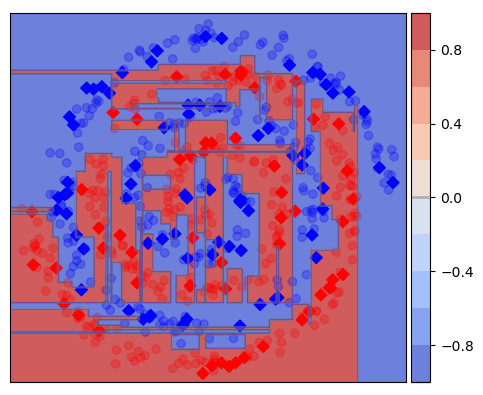

In [100]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, best_dt)

In [101]:
# LEAVE BLANK

In [102]:
# LEAVE BLANK

In [103]:
# LEAVE BLANK

In [104]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 8: Model selection with Scikit-learn GridSearchCV</b>

The previous custom grid search was limited, as it only optimized the hyperparameters of a decision tree classifier on a simple 2D synthetic dataset. Now, let’s extend this process by using Scikit-learn’s `GridSearchCV` in combination with pipelines to broaden our search across a more complex dataset and test the parameters of each step within the pipeline.

This exercise is open-ended, allowing you to explore and tune hyperparameters from any pipeline component, such as scalers, imputers, transformers, encoders, or model algorithms. Don’t restrict yourself to linear models or decision trees; instead, experiment with a variety of models, such as XGBoost or SVM classifiers. Finally, return the estimated generalization performance of the selected model.

<br><i>[5 points]</i>
</div>
<div class="alert alert-success">

<b>About the two datasets used in this exercise</b>

<u>Context</u>

Superheroes have been in popular culture for a long time, and now more than ever. Since its creation, superheroes have not been diverse, but this is changing rapidly. The two datasets aim to provide an overview of heroes and their physical and power characteristics, helping curious people to identify trends and patterns. In this case, we want to understand how physical attributes and powers define superheroes' alignment (superhero, supervillain).

<u>Content</u>
    
The columns included in both datasets are: 
- **Dataset part 1**: Name, Gender, Eye color, Race, Hair color, Height, Publisher, Skin color, Alignment, Weight,Has Superpowers, Power Level, Intelligence Level
- **Dataset part 2**: Previous columns and, Agility, Accelerated Healing, Lantern Power Ring, Dimensional Awareness, Cold Resistance, Durability, Stealth, Energy Absorption, Flight, Danger Sense, Underwater breathing, Marksmanship, Weapons Master, Power Augmentation, Animal Attributes, Longevity, Intelligence, Super Strength, Cryokinesis, Telepathy, Energy Armor, Energy Blasts, Duplication, Size Changing, Density Control, Stamina, Astral Travel,Audio Control, Dexterity, Omnitrix, Super Speed, Possession, Animal Oriented Powers, Weapon-based Powers, Electrokinesis, Darkforce Manipulation, Death Touch, Teleportation, Enhanced Senses, Telekinesis, Energy Beams, Magic, Hyperkinesis, Jump, Clairvoyance, Dimensional Travel, Power Sense, Shapeshifting, Peak Human Condition, Immortality, Camouflage, Element Control, Phasing, Astral Projection, Electrical Transport, Fire Control,Projection, Summoning, Enhanced Memory, Reflexes, Invulnerability, Energy Constructs, Force Fields, Self-Sustenance ,Anti-Gravity, Empathy, Power Nullifier, Radiation Control, Psionic Powers, Elasticity, Substance Secretion, Elemental Transmogrification, Technopath/Cyberpath, Photographic Reflexes, Seismic Power, Animation, Precognition, Mind Control, Fire Resistance, Power Absorption, Enhanced Hearing, Nova Force, Insanity, Hypnokinesis, Animal Control, Natural Armor, Intangibility, Enhanced Sight, Molecular Manipulation, Heat Generation, Adaptation, Gliding, Power Suit, Mind Blast, Probability Manipulation, Gravity Control, Regeneration, Light Control, Echolocation, Levitation, Toxin and Disease Control, Banish, Energy Manipulation, Heat Resistance, Natural Weapons, Time Travel, Enhanced Smell, Illusions, Thirstokinesis, Hair Manipulation, Illumination, Omnipotent, Cloaking, Changing Armor, Power Cosmic, Biokinesis, Water Control, Radiation Immunity, Vision - Telescopic, Toxin and Disease Resistance, Spatial Awareness, Energy Resistance, Telepathy Resistance, Molecular Combustion, Omnilingualism, Portal Creation, Magnetism, Mind Control Resistance, Plant Control, Sonar, Sonic Scream, Time Manipulation, Enhanced Touch, Magic Resistance, Invisibility, Sub-Mariner, Radiation Absorption, Intuitive aptitude, Vision - Microscopic, Melting, Wind Control, Super Breath, Wallcrawling, Vision - Night, Vision - Infrared, Grim Reaping, Matter Absorption, The Force, Resurrection, Terrakinesis, Vision - Heat, Vitakinesis, Radar Sense, Qwardian Power Ring, Weather Control, Vision - X-Ray, Vision - Thermal, Web Creation, Reality Warping, Odin Force, Symbiote Costume, Speed Force, Phoenix Force, Molecular Dissipation, Vision - Cryo, Omnipresent, Omniscient.

Column names are self-explanatory. Physical attributes are numerical or categorical, while superpowers are dummy (Onehot) variables.

</div>

<div class="alert alert-warning">
Before starting the grid search, merge the datasets using Pandas on name and publisher.
</div>

In [105]:
# DO NOT MODIFY NOR ADD CODE TO THIS CELL
import pandas as pd

df_physical_traits = pd.read_csv('https://raw.githubusercontent.com/jnin/information-systems/refs/heads/main/data/superheroes_superpowers.csv', index_col=False)
df_superpowers = pd.read_csv(' https://raw.githubusercontent.com/jnin/information-systems/refs/heads/main/data/superheroes_%20physical_traits.csv', index_col=False)
print(df_physical_traits.columns)
print(df_superpowers.columns)



Index(['name', 'Publisher', 'Agility', 'Accelerated Healing',
       'Lantern Power Ring', 'Dimensional Awareness', 'Cold Resistance',
       'Durability', 'Stealth', 'Energy Absorption',
       ...
       'Web Creation', 'Reality Warping', 'Odin Force', 'Symbiote Costume',
       'Speed Force', 'Phoenix Force', 'Molecular Dissipation',
       'Vision - Cryo', 'Omnipresent', 'Omniscient'],
      dtype='object', length=169)
Index(['Name', 'Gender', 'Eye color', 'Race', 'Hair color', 'Height',
       'Publisher', 'Skin color', 'Alignment', 'Weight', 'Has Superpowers',
       'Power Level', 'Intelligence Level'],
      dtype='object')


In [166]:
# YOUR CODE HERE
# Import necessary libraries

import pandas as pd
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
# Import XGBoost
from xgboost import XGBClassifier, XGBRegressor


# Load your datasets (replace these with actual data load steps)
# dataset1 = pd.read_csv('dataset1.csv')
# dataset2 = pd.read_csv('dataset2.csv')
df_physical_traits.rename(columns={'name': 'Name'}, inplace=True)

# Merge the two datasets on 'name' and 'publisher'
df = pd.merge(df_physical_traits, df_superpowers, on=['Name', 'Publisher'], how='inner')

# Check the data to make sure it's merged properly
print(df.head())

# Step 1: Data Preprocessing
print(df_physical_traits.columns)

# 1.1 Define target and features
X = df.drop(columns=['Alignment','Name','Publisher','Eye color'])  # Exclude the target column
y = df['Alignment']  # Target column (alignment: superhero/supervillain)
# Handling the negative values for Weight and Height and replacing them with NaN so we can faciliate imputation later on
import numpy as np # Importing NumPy for numerical operations
X['Weight'] = np.where(X['Weight'] < 0, np.nan, X['Weight'])
X['Height'] = np.where(X['Height'] < 0, np.nan, X['Height'])

# # Assuming `df` is your DataFrame and 'column_name' is the column of interest

# unique_values = df['Intelligence Level'].unique()

# # Convert to a list (optional, if needed in list format)
# unique_values_list = unique_values.tolist()

# print("Unique Values:")
# print(unique_values_list)

categorical_columns = ['Gender', 'Race', 'Hair color','Skin color']
numerical_columns = ['Height', 'Weight']
ordinal_columns = ['Power Level', 'Intelligence Level']
ordinal_categories = [
    ['Weak', 'Below Average', 'Average', 'Above Average', 'Extremely Powerful'],
    ['Low Intelligence', 'Average Intelligence', 'Smart', 'Genius', 'Super-Genius']
]
boolean_columns = X.select_dtypes(include=['bool']).columns


# Initialize the imputers and encoders
numerical_imputer = SimpleImputer(strategy='median')  # Replace missing numerical values with the median
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Replace missing categorical values with the most frequent value
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

# Handling the numerical data
# We first replace all missing values with the median and then we scale all of them
# We are usning median and scaling as we have some extreme values like weight=400kg
from sklearn.preprocessing import StandardScaler
numerical_pipeline = Pipeline(steps=[
    ('imputer', numerical_imputer), 
    ('scaler', StandardScaler()) 
]
)

# Handling the categorical data
# We first replace all missing categorical values with the mode and then we encode them
categorical_pipeline = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('onehot', one_hot_encoder)
]
)

# Step 2 of Handling missing data/...
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Transformer to convert True/False to 0/1
bool_to_int_transformer = FunctionTransformer((lambda x: x.astype(float)), validate=False)

# Update the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
        ('ord', ordinal_encoder, ordinal_columns),
        ('bool', bool_to_int_transformer,boolean_columns)  # Handle True/False columns
    ],
    remainder='passthrough'  # Pass remaining columns as-is if any
)


# The pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
  # Default model
])

# # Step 7: Fit and transform the dataset
# X_pipe = pipe.fit_transform(X)
# non_numeric_columns = X_pipe.select_dtypes(exclude=['number']).columns

# # Print the non-numeric columns
# print("Non-numeric columns:", non_numeric_columns)

# print(X_pipe)
# print(X_pipe.dtypes)

param_grid = [
    # RandomForestClassifier: Tuning hyperparameters related to RandomForest
     {
        'model': [RandomForestClassifier(random_state=42)],
        'model__max_features': ['sqrt', 'log2', None],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__class_weight': ['balanced', 'balanced_subsample']
    },
    {
        'model': [XGBClassifier(scale_pos_weight=1, random_state=42)],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.1],
        'model__gamma': [0.1, 0.5], 
    },
    # SVC: Support Vector Classifier
    {
        'model': [SVC(class_weight='balanced')],
        'model__C': [0.001, 0.1, 1, 10, 100],  # Regularization parameter
        'model__kernel': ['linear', 'rbf']  # Kernel type for SVC
    },
    # DecisionTreeClassifier: Tuning decision tree parameters
    {
        'model': [DecisionTreeClassifier()],
        'model__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
        'model__splitter': ['best', 'random'],  # Strategy for splitting nodes
        'model__max_depth': [None, 10, 20, 30],  # Max depth of the tree
        'model__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
        'model__min_samples_leaf': [1, 2, 4]  # Minimum samples required to be at a leaf node
    }
]


# print(X_train.dtypes)  # Check feature data types
# print(y_train.unique())  # Check unique target values


# 4.2 Perform GridSearchCV
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
import numpy as np

# If y is a numpy array
print(y.dtype)
print(np.unique(y))  # Use numpy's unique method

# 4.3 Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

grid_search.fit(X_train, y_train)

# Step 5: Evaluate the best model found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Step 6: Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, y_pred))


          Name          Publisher  Agility  Accelerated Healing  \
0       A-Bomb      Marvel Comics    False                 True   
1   Abe Sapien  Dark Horse Comics     True                 True   
2     Abin Sur          DC Comics    False                False   
3  Abomination      Marvel Comics    False                 True   
4      Abraxas      Marvel Comics    False                False   

   Lantern Power Ring  Dimensional Awareness  Cold Resistance  Durability  \
0               False                  False            False        True   
1               False                  False             True        True   
2                True                  False            False       False   
3               False                  False            False       False   
4               False                   True            False       False   

   Stealth  Energy Absorption  ...  Eye color               Race  Hair color  \
0    False              False  ...     yellow         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:44]

Best parameters found:  {'model': RandomForestClassifier(random_state=42), 'model__class_weight': 'balanced_subsample', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.62      0.14      0.22        37
           1       0.68      0.98      0.80        85
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         2

    accuracy                           0.68       130
   macro avg       0.33      0.28      0.26       130
weighted avg       0.62      0.68      0.59       130



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
